In [141]:
import pandas as pd
import io
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import re
import seaborn as sns
from fbprophet import Prophet
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [125]:
url = 'http://files.zillowstatic.com/research/public/Zip/Zip_Zhvi_SingleFamilyResidence.csv'
df = pd.read_csv(url)
df=df.rename(columns={'RegionName':'ZipCode'})
df.head(100)

df_1 = pd.read_csv(url)
df_1=df_1.rename(columns={'RegionName':'ZipCode'})

df_zips = pd.read_csv(url)
df_zips=df_zips.rename(columns={'RegionName':'ZipCode'})

df_test = pd.read_csv(url)
df_test=df_test.rename(columns={'RegionName':'ZipCode'})

df_1.head( )

,RegionID,SizeRank,ZipCode,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,...,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1524562.000,1525605.000,1525955.000,1528604.000,1527843.000,1530509.000,1525013.000,1531236.000,1532307.000,1543260.000,1534946.000,1527048.000,1508495.000,1498638.000,1494872.000,1487969.000,1480591.000,1471324.000,1462476.000,1456223.000,1448110.000,1446622.000,1451579.000,1452858.000,1453112.000,1439554.000,1426900.000,1416568.000,1415022.000,1414474.000,1413747.000,1405862.000,1402547.000,1390420.000,1381621.000,1375725.000,1374714.000,1381453.000,1385737.000,1389268.000
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,364892.000,364162.000,363605.000,362963.000,361660.000,361342.000,360662.000,361804.000,363561.000,366592.000,370077.000,372842.000,376806.000,380122.000,384081.000,385663.000,389062.000,389359.000,390182.000,388087.000,385729.000,381688.000,377848.000,376493.000,374914.000,375094.000,375012.000,378067.000,380789.000,386605.000,392801.000,...,958178.000,956528.000,951529.000,955244.000,958096.000,959882.000,958726.000,956879.000,958371.000,961171.000,960878.000,957985.000,958428.000,964051.000,969547.000,968807.000,968566.000,969572.000,972936.000,973010.000,972447.000,972684.000,975094.000,978629.000,981362.000,979667.000,976810.000,975419.000,975366.000,975741.000,974693.000,975616.000,975734.000,975251.000,974238.000,973104.000,971908.000,972038.000,973671.000,975642.000
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1669910.000,1661199.000,1639318.000,1622378.000,1613382.000,1611625.000,1609075.000,1611388.000,1615755.000,1619823.000,1609176.000,1597282.000,1581756.000,1572273.000,1573601.000,1578799.000,1585506.000,1587796.000,1591265.000,1596660.000,1598258.000,1596017.000,1595032.000,1592948.000,1590038.000,1576594.000,1562766.000,1552128.000,1545711.000,1540137.000,1528603.000,1514894.000,1502233.000,1492429.000,1486122.000,1480426.000,1476509.000,1478980.000,1479301.000,1474994.000
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,200475.000,200723.000,200526.000,199337.000,198200.000,197534.000,198298.000,197986.000,197333.000,196543.000,197444.000,199129.000,201687.000,202931.000,204207.000,206413.000,208870.000,210582.000,210250.000,212394.000,214904.000,217109.000,216177.000,214468.000,211736.000,210126.000,208420.000,207481.000,206443.000,206033.000,205925.000,...,331031.000,330770.000,331485.000,332276.000,332365.000,331319.000,331016.000,331256.000,331356.000,331165.000,331177.000,331223.000,332171.000,333159.000,333470.000,333247.000,333699.000,334667.000,335386.000,335194.000,335478.000,335777.000,336150.000,336558.000,336390.000,336776.000,336806.000,336869.000,336217.000,335679.000,335536.000,335878.000,335940.000,336092.000,336119.000,336083.000,336154.000,335860.000,336037.000,336483.000
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Nape

In [30]:
print('States', len(df['State'].unique()))
print('Cities ', len(df['City'].unique()))
print('Zipcodes ', len(df['RegionID'].unique()))
print('List of States:',df['State'].unique())
df.dtypes
 

States 51
Cities  14862
Zipcodes  30464
List of States: ['NY' 'IL' 'TX' 'CA' 'LA' 'TN' 'FL' 'DC' 'NC' 'GA' 'OK' 'MO' 'NJ' 'WA'
 'AZ' 'MD' 'VA' 'MA' 'CO' 'MI' 'OH' 'KS' 'PA' 'NM' 'OR' 'CT' 'NV' 'IN'
 'SC' 'KY' 'AL' 'ND' 'MN' 'AR' 'DE' 'MS' 'ID' 'MT' 'HI' 'WI' 'UT' 'ME'
 'WV' 'SD' 'NE' 'IA' 'RI' 'WY' 'AK' 'NH' 'VT']


RegionID        int64
SizeRank        int64
ZipCode         int64
RegionType     object
StateName      object
               ...   
2019-11-30    float64
2019-12-31    float64
2020-01-31    float64
2020-02-29    float64
2020-03-31    float64
Length: 300, dtype: object

Importing the data set and seeing what variables we have

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



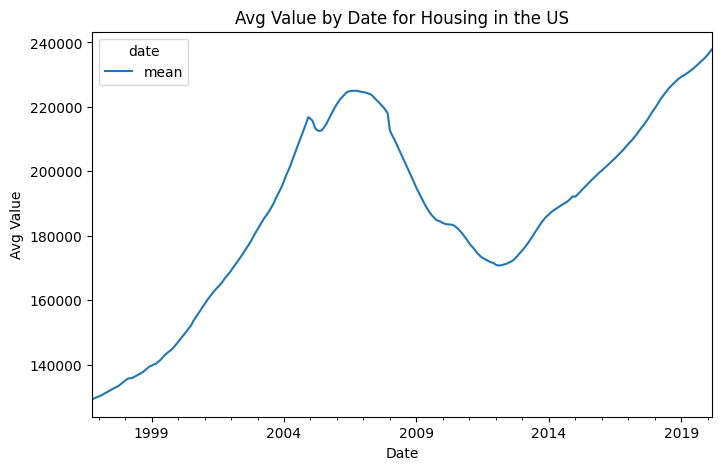

In [108]:
#the ugliest thing i have created
#df.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'], axis = 1, inplace = True)

#df.set_index('ZipCode', inplace=True)

df_all = df.T

df_all = df_all.iloc[11:]
df_all 
df_all['mean'] = df_all.mean(axis=1)

df_all.reset_index(inplace=True)
df_all = df_all.melt(id_vars = 'index', var_name = 'date', value_name = 'house_price')
df_all
df_plot = df_all.loc[df_all['date'] == 'mean']


df_plot['index']=pd.to_datetime(df_plot['index'], infer_datetime_format=True)
df_plot
df_plot.drop(columns=['date'])
df_plot = df_plot.pivot(index='index', columns='date', values='house_price')

# #df_allplot = df_all.pivot(index='date', columns='index', values='house_price')
df_plot.plot(figsize=(8,5))
_ = plt.xlabel('Date')
_ = plt.ylabel('Avg Value')
_ = plt.title('Avg Value by Date for Housing in the US')


In [95]:
ak_city = ['Hot Springs', 'Little Rock', 'Fayetteville', 'Searcy']

for city in ak_city:
  if city == 'Hot Springs':
    temp = df[df['City'].isin([city])]
    HS_List = temp['ZipCode'].tolist()
  elif city == 'Little Rock': 
    temp = df[df['City'].isin([city])]
    LR_List = temp['ZipCode'].tolist()
  elif city == 'Fayetteville':
    temp = df[df['Metro'].isin([city])]
    F_List = temp['ZipCode'].tolist()
  elif city == 'Searcy':
    temp = df[df['Metro'].isin([city])]
    S_List = temp['ZipCode'].tolist()


In [96]:
df.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'], axis = 1, inplace = True)
cols = [c for c in df.columns if c.lower()[:4] != '1996']
df=df[cols]
df.set_index('ZipCode', inplace=True)
df = df.T
df.head()

ZipCode,10025,60657,10023,77494,60614,77449,10002,77084,79936,60640,11226,10467,78660,94109,926,10016,37013,32162,60647,11201,11235,11375,90250,78130,37211,10029,10009,77573,60618,77584,10011,20002,10128,28269,78613,77433,78572,30349,79912,75052,...,8541,2714,1615,52204,56210,2912,32511,25305,32072,55144,21405,63875,86343,20052,75599,501,1063,3575,20635,22807,2203,93282,40404,89155,84322,95229,73019,95721,77399,38959,4420,4109,7703,742,803,802,820,822,831,851
1997-01-31,nan,376806.000,nan,201687.000,566446.000,97543.000,nan,96895.000,82953.000,260247.000,218277.000,236747.000,145852.000,634547.000,nan,nan,118805.000,109220.000,178312.000,540189.000,239406.000,290556.000,171912.000,nan,117713.000,nan,nan,134785.000,226704.000,143642.000,nan,135155.000,nan,137067.000,163499.000,164981.000,nan,100446.000,124296.000,99937.000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,66802.000,399413.000,nan,74398.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,195628.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1997-02-28,nan,380122.000,nan,202931.000,569659.000,97263.000,nan,96481.000,82909.000,263887.000,220406.000,237584.000,146293.000,644534.000,nan,nan,119283.000,108399.000,180167.000,548016.000,241077.000,293279.000,171000.000,nan,118294.000,nan,nan,135243.000,227959.000,144231.000,nan,135393.000,nan,137895.000,164226.000,164519.000,nan,100553.000,124411.000,100034.000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,66467.000,399214.000,nan,75831.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,196315.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1997-03-31,nan,384081.000,nan,204207.000,573409.000,97003.000,nan,96141.000,82860.000,267644.000,223430.000,238301.000,146762.000,651405.000,nan,nan,119844.000,108309.000,181400.000,555464.000,241865.000,296133.000,170079.000,nan,119005.000,nan,nan,135834.000,228968.000,144419.000,nan,135957.000,nan,138691.000,164506.000,163989.000,nan,100779.000,124474.000,100109.000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,66594.000,399650.000,nan,77102.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,196636.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1997-04-30,nan,385663.000,nan,206413.000,575403.000,97138.000,nan,96098.000,83044.000,271519.000,225742.000,240098.000,147072.000,650214.000,nan,nan,120430.000,107729.000,181015.000,560574.000,242379.000,298860.000,169778.000,nan,119731.000,nan,nan,136810.000,228495.000,144782.000,nan,137073.000,nan,139244.000,163904.000,163744.000,nan,101177.000,124684.000,100352.000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,66891.000,397422.000,nan,78735.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,197383.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1997-05-31,nan,389062.000,nan,208870.000,581567.000,97277.000,nan,96112.000,83059.000,276393.000,226826.000,240305.000,147212.000,655155.000,nan,nan,120880.000,107962.000,182186.000,568520.000,241423.000,300434.000,169444.000,nan,120410.000,nan,nan,137574.000,229011.000,145112.000,nan,137423.000,nan,139509.000,163171.000,163502.000,nan,101597.000,124566.000,100548.000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,67367.000,398294.000,nan,80066.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,198061.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [97]:

#create dataframes and find the mean
HS = df[HS_List]
HS = HS.mean(axis=1)
LR = df[LR_List]
LR = LR.mean(axis=1)
FAY = df[F_List]
FAY = FAY.mean(axis=1)
SEA = df[S_List]
SEA = SEA.mean(axis=1)

plot_AK = pd.DataFrame([HS, LR, FAY, SEA], index= ['Hot Springs', 'Little Rock', 'Fayetteville', 'Searcy'])
# for i in plot_AK:
#   plot_AK[i] = plot_AK[i].replace('0', 'Hot Springs', regex=True)
#   plot_AK[i] = plot_AK[i].replace('1','Little Rock', regex=True)
#   plot_AK[i] = plot_AK[i].replace('2','Fayetteville', regex=True)
#plot_AK = plot_AK.set_index(['Hot Springs', 'Little Rock', 'Fayetteville', 'Searcy']) 
plot_AK.head()
plot_AK.reset_index(inplace=True)
plot_AKdf = plot_AK.melt(id_vars = 'index', var_name = 'date', value_name = 'house_price')


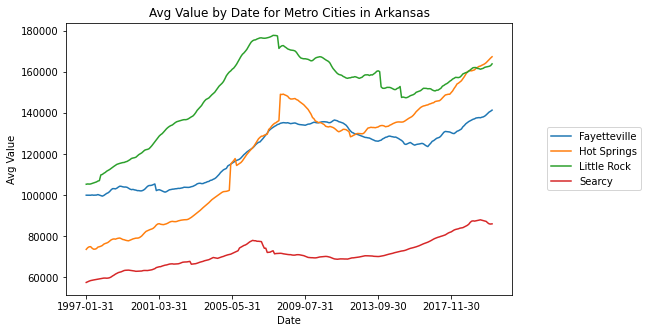

In [98]:
df_AK = plot_AKdf.pivot(index='date', columns='index', values='house_price')
df_AK.plot(figsize=(8,5))
_ = plt.xlabel('Date')
_ = plt.ylabel('Avg Value')
_ = plt.title('Avg Value by Date for Metro Cities in Arkansas')
plt.legend(loc='center right', bbox_to_anchor=[1.3, 0.5])
plt.show()

In [161]:
cols = [c for c in df_1.columns if c.lower()[:4] != '1996']
df_1=df_1[cols]
cols1 = [c for c in df_1.columns if c.lower()[:4] != '2018']
df_1=df_1[cols1]
cols2 = [c for c in df_1.columns if c.lower()[:4] != '2019']
df_1=df_1[cols2]
cols3 = [c for c in df_1.columns if c.lower()[:4] != '2020']
df_1=df_1[cols3]

state = ['CA', 'IL', 'MI', 'WA', 'NY']
#because i would want to live in these states, fix these states

df_train = df_1[df_1.StateName.isin(state)]

df_train.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'], axis = 1, inplace = True)
df_train.set_index('ZipCode', inplace=True)
to_obs = df_train.iloc[:, 7:]

df_train = df_train.T
df_train.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ZipCode,10025,60657,10023,60614,10002,60640,11226,10467,94109,10016,60647,11201,11235,11375,90250,10029,10009,60618,10011,10128,94565,11206,90046,10462,10456,60613,10019,10003,60625,11230,11212,10463,60629,11209,11221,98052,60610,10024,11214,11207,...,98421,99105,48870,60926,49035,92332,99136,96132,13482,99174,93435,49877,61057,48833,61331,93519,13134,49311,14508,96061,49819,95141,61328,93522,12911,95980,99333,99144,99154,62252,98950,62059,99104,95375,98068,10979,501,93282,95229,95721
1997-01-31,nan,376806.000,nan,566446.000,nan,260247.000,218277.000,236747.000,634547.000,nan,178312.000,540189.000,239406.000,290556.000,171912.000,nan,nan,226704.000,nan,nan,nan,197237.000,181754.000,212299.000,nan,353824.000,nan,nan,188251.000,270756.000,228286.000,303869.000,89918.000,342898.000,235924.000,249077.000,344997.000,nan,234822.000,175522.000,...,73741.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,149125.000,67157.000,nan,nan,738124.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1997-02-28,nan,380122.000,nan,569659.000,nan,263887.000,220406.000,237584.000,644534.000,nan,180167.000,548016.000,241077.000,293279.000,171000.000,nan,nan,227959.000,nan,nan,nan,198753.000,181892.000,213829.000,nan,359196.000,nan,nan,189665.000,273487.000,228176.000,307023.000,90287.000,344702.000,236853.000,250829.000,346264.000,nan,235410.000,176394.000,...,74533.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,148921.000,67290.000,nan,nan,743382.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1997-03-31,nan,384081.000,nan,573409.000,nan,267644.000,223430.000,238301.000,651405.000,nan,181400.000,555464.000,241865.000,296133.000,170079.000,nan,nan,228968.000,nan,nan,nan,201620.000,182984.000,215453.000,nan,365246.000,nan,nan,190755.000,275732.000,228486.000,309444.000,90662.000,346211.000,238884.000,252904.000,348357.000,nan,235503.000,177573.000,...,75061.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,147945.000,66557.000,nan,nan,751757.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1997-04-30,nan,385663.000,nan,575403.000,nan,271519.000,225742.000,240098.000,650214.000,nan,181015.000,560574.000,242379.000,298860.000,169778.000,nan,nan,228495.000,nan,nan,nan,203257.000,185234.000,217014.000,nan,369386.000,nan,nan,191191.000,276381.000,228689.000,311021.000,90775.000,346859.000,240448.000,255229.000,348629.000,nan,235970.000,178562.000,...,76117.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,147893.000,66001.000,nan,nan,750816.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1997-05-31,nan,389062.000,nan,581567.000,nan,276393.000,226826.000,240305.000,655155.000,nan,182186.000,568520.000,241423.000,300434.000,169444.000,nan,nan,229011.000,nan,nan,nan,205061.000,187349.000,218003.000,nan,374742.000,nan,nan,192886.000,276824.000,229406.000,309969.000,91231.000,349444.000,242941.000,258172.000,353151.000,nan,236147.000,178873.000,...,77005.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,148906.000,65576.000,nan,nan,756576.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [160]:
#df_test = df_test.filter(regex='2018',axis=1).head()
#testing = df_test.iloc[0] 
testing.mean()

1467031.1666666667

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



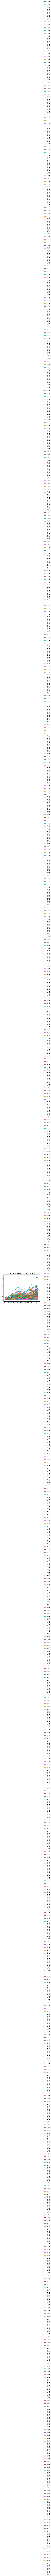

In [121]:
#want to see something truly ugly? look no further
CA=['CA']
df_CA = df_1[df_1.StateName.isin(CA)]
df_CA.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'], axis = 1, inplace = True)
df_CA.set_index('ZipCode', inplace=True)
df_CA = df_CA.T
df_CA.reset_index(inplace=True)
df_CA_Plot = df_CA.melt(id_vars = 'index', var_name = 'zip', value_name = 'house_price')
df_CA_Plot.head()

CA_plot = df_CA_Plot.pivot(index='index', columns='zip', values='house_price')
CA_plot.plot()
_ = plt.xlabel('Date')
_ = plt.ylabel('Avg Value')
_ = plt.title('Avg Value by Date for All Cities in California')
plt.legend(loc='center right', bbox_to_anchor=[1.3, 0.5])
plt.show()

In [35]:
#Create a list of dataframes by zipcode 
dfs = []
dfi=[]
for i, zip in enumerate(df_train.columns):
    # add only from first valid index
    dfs.append(df_train.loc[df_train.loc[:,zip].first_valid_index():,zip])
    dfs[i] = dfs[i].to_frame()
    dfs[i].name = zip
    dfs[i]['ds'] = dfs[i].index
    dfs[i].rename(columns={zip: 'y'}, inplace=True)
print(dfs[0].name)
dfi = pd.DataFrame(dfs[0])
dfi['ds'] = pd.to_datetime(dfi['ds'], infer_datetime_format=True)


10025


In [162]:
# dfi.dtypes


In [163]:
#dfs['ds'] = pd.to_datetime(dfs['ds'], infer_datetime_format=True)


In [152]:

model1=Prophet(growth='linear')
model1.add_seasonality(name='monthly', period=31, fourier_order=12)
trainings = dfi
trainings.columns = ['y','ds']
model1.fit(trainings)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds        yhat  yhat_lower  yhat_upper
0 2018-01-01 1512969.598 1464606.154 1562556.289
1 2018-02-01 1525054.429 1479951.748 1574819.200
2 2018-03-01 1538941.498 1491489.546 1589083.819
3 2018-04-01 1546696.216 1497387.585 1599990.850
4 2018-05-01 1510713.280 1462848.181 1558825.659


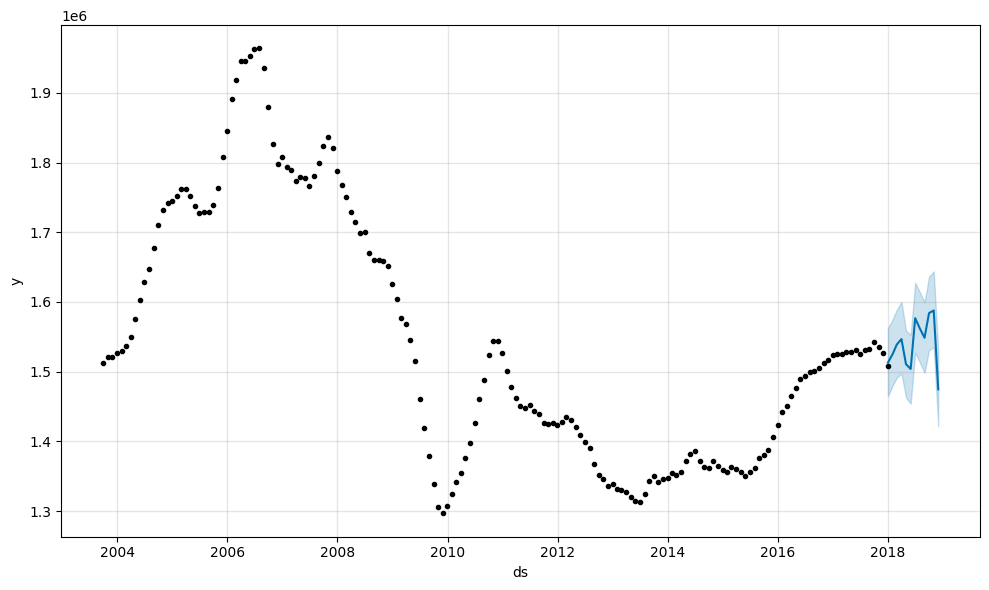

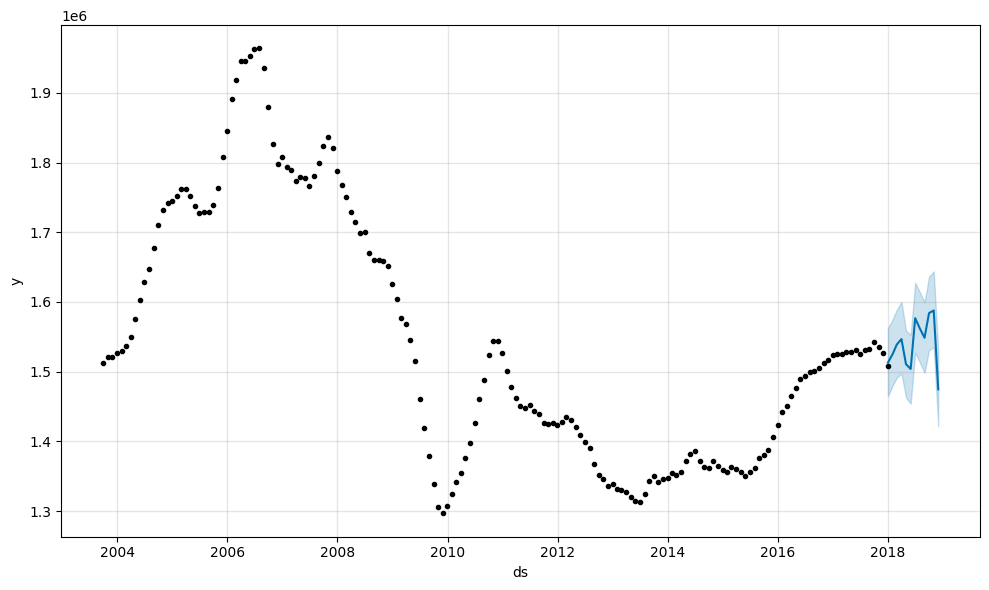

In [153]:
future = list()
for i in range(1, 13):
	date = '2018-%02d' % i
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
forecast = model1.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
model1.plot(forecast)

#help to create this taken from machinelearningmastery

In [154]:
yhat = forecast['yhat']
yhat

0    1512969.598
1    1525054.429
2    1538941.498
3    1546696.216
4    1510713.280
5    1503861.666
6    1576785.036
7    1561854.823
8    1548663.331
9    1584076.006
10   1587799.638
11   1474637.275
Name: yhat, dtype: float64

In [157]:
df_test = df.loc[df['ZipCode'] == '10025'] #this isn't working fix later
df_test = 1498638.000

mae = metrics.mean_absolute_error(testing, yhat)
mse = metrics.mean_squared_error(testing, yhat)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(testing,yhat)

print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

MAE: 72306.56632879512
MSE: 7121859993.194377
RMSE: 84391.11323589929
R-Squared: -20.579779644081153


In [156]:
#df_zips.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'], axis = 1, inplace = True)
#df_zips.set_index('ZipCode', inplace=True)
df_zips.head()
diffs=[]
df_zips['Score_diff'] = (df_zips['2017-03-31'].sub(df_zips['2000-03-31'], axis = 0))/df_zips['2000-03-31'] 
df_zips.head()
# df_zips.loc[df_zips['Score_diff'].idxmax()]
# df_zips = df_zips[df_zips.ZipCode != 91108]
# df_zips.loc[df_zips['Score_diff'].idxmax()]
# df_zips = df_zips[df_zips.ZipCode != 90403]
# df_zips.loc[df_zips['Score_diff'].idxmax()]
#df = pd.DataFrame({'lab':['A', 'B', 'C'], 'val':[10, 30, 20]})
df_zips.loc[df_zips['Score_diff'].idxmin()]
df_zips = df_zips[df_zips.ZipCode != 36105]
df_zips.loc[df_zips['Score_diff'].idxmin()]
# df_zips = df_zips[df_zips.ZipCode != 44049]
# df_zips.loc[df_zips['Score_diff'].idxmin()]


RegionID         76963
SizeRank         30742
ZipCode          44049
RegionType         Zip
StateName           OH
                ...   
2019-12-31   93394.000
2020-01-31   94098.000
2020-02-29   94035.000
2020-03-31   94410.000
Score_diff      -0.603
Name: 28267, Length: 301, dtype: object

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



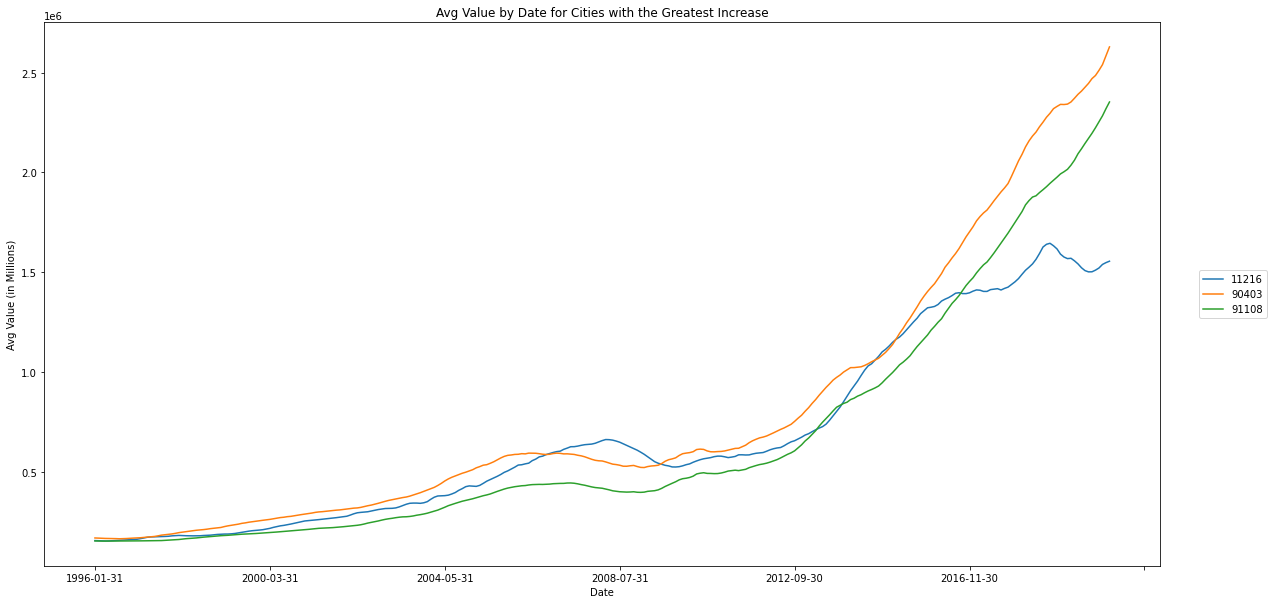

In [74]:
zipped= [91108, 90403, 11216]
df_largest = df_1[df_1.ZipCode.isin(zipped)]
df_largest.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'], axis = 1, inplace = True)
df_largest.set_index('ZipCode', inplace=True)
df_largest = df_largest.T
df_largest.reset_index(inplace=True)
df_largest_Plot = df_largest.melt(id_vars = 'index', var_name = 'zip', value_name = 'house_price')
df_largest_Plot.head()

largest_plot = df_largest_Plot.pivot(index='index', columns='zip', values='house_price')
largest_plot.plot(figsize=(20,10))
_ = plt.xlabel('Date')
_ = plt.ylabel('Avg Value (in Millions)')
_ = plt.title('Avg Value by Date for Cities with the Greatest Increase')
plt.legend(loc='center right', bbox_to_anchor=[1.1, 0.5])
plt.show()

we are calculating the percentage change between 2000 and 2017 to see what three zipcodes had the greatest increase and would make the best investment. Largest is 91108 with 6.37, second is 90403 with 5.907, third is 11216 with 5.522

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



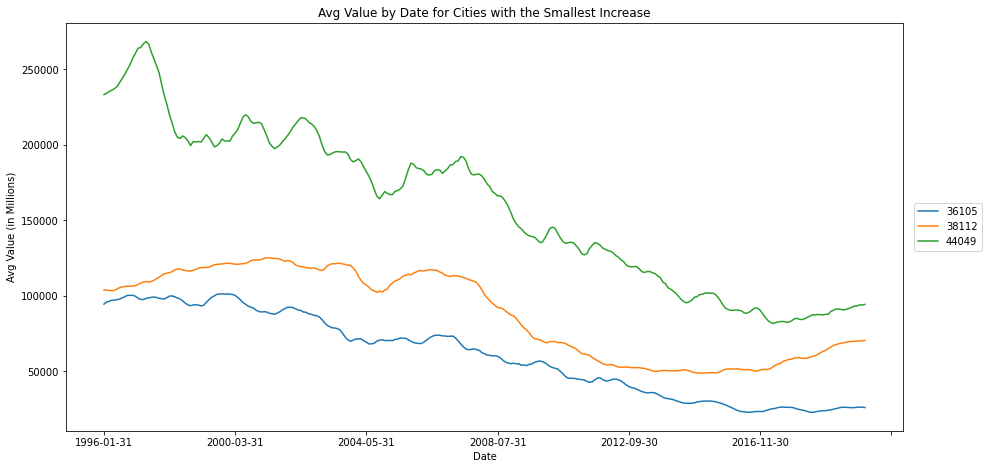

In [83]:
zipped= [36105, 44049, 38112]
df_smallest = df_1[df_1.ZipCode.isin(zipped)]
df_smallest.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'], axis = 1, inplace = True)
df_smallest.set_index('ZipCode', inplace=True)
df_smallest = df_smallest.T
df_smallest.reset_index(inplace=True)
df_smallest_Plot = df_smallest.melt(id_vars = 'index', var_name = 'zip', value_name = 'house_price')
df_smallest_Plot.head()

smallest_plot = df_smallest_Plot.pivot(index='index', columns='zip', values='house_price')
smallest_plot.plot(figsize=(15,7.5))
_ = plt.xlabel('Date')
_ = plt.ylabel('Avg Value (in Millions)')
_ = plt.title('Avg Value by Date for Cities with the Smallest Increase')
plt.legend(loc='center right', bbox_to_anchor=[1.1, 0.5])
plt.show()